In [1]:
import tensorflow as tf
import numpy as np

2022-12-17 17:40:21.602781: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-17 17:40:26.889785: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-17 17:40:37.707491: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/root/miniconda3/envs/mp/lib/
2022-12-17 17:40:37.707781: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7:

In [2]:
from tensorflow.keras.layers import Conv1D, MaxPool1D, LSTM, Dense, MultiHeadAttention, LayerNormalization, Flatten

In [52]:
class ResNetToTransformer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.resnet = ResNet1D()
        self.transformer_layer_1 = TransformerMini()
        self.flatten = Flatten()
        self.fc2 = Dense(1, activation = 'sigmoid')
        
        l = []

        for i in range(154):
            tl = []
            for j in range(128):
                tl.append(np.sin((i + 1) / np.power(10000, 2*j / 256)))
                tl.append(np.cos((i + 1) / np.power(10000, 2*j / 256)))

            l.append(tl)
        
        self.pos_enc = tf.constant(np.array(l), dtype = tf.float32)

    

    def call(self, x):
        out1 = self.transformer_layer_1(self.resnet(x) + self.pos_enc)
        out2 = self.flatten(out1)
        return self.fc2(out2)


class TransformerMini(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.transformer_layer_1 = TransformerLayer(256, 256)
        self.transformer_layer_2 = TransformerLayer(256, 256)

    def call(self, x):
        return self.transformer_layer_2(self.transformer_layer_1(x))



class TransformerLayer(tf.keras.layers.Layer):
    def __init__(self, key_dim, value_dim, **kwargs):
        super().__init__(**kwargs)
        self.MHA = MultiHeadAttention(num_heads = 8, key_dim = key_dim, value_dim = value_dim)
        self.layer_norm_1 = LayerNormalization()
        self.w1 = tf.Variable(np.random.rand(256, 1024), dtype = tf.float32)
        self.b1 = tf.Variable(np.random.rand(1, 1024), dtype = tf.float32)
        self.relu = tf.nn.relu
        self.w2 = tf.Variable(np.random.rand(1024, 256), dtype = tf.float32)
        self.b2 = tf.Variable(np.random.rand(1, 256), dtype = tf.float32)
        self.layer_norm_2 = LayerNormalization()

    def call(self, x):
        mha_out = self.MHA(x, x, x)
        norm_out = self.layer_norm_1(x + mha_out)
        relu_out = self.relu(norm_out@self.w1 + self.b1)
        ff_out = relu_out@self.w2 + self.b2
        norm_out2 = self.layer_norm_2(norm_out + ff_out)
        return norm_out2




class ResNet1D(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv_pre = ResNetPreLayer(300, 64)
        self.conv1 = ResNetLayer1D(64, 128)
        self.conv2 = ResNetLayer1D(128, 256)
        self.conv3 = ResNetLayer1D(256, 256)

    def call(self, x):
        return self.conv3(self.conv2(self.conv1(self.conv_pre(x))))


class ResNetPreLayer(tf.keras.layers.Layer):
    def __init__(self, in_dim, out_dim, **kwargs):
        super().__init__(**kwargs)
        self.conv = Conv1D(out_dim, 5, activation = 'relu', input_shape = (None, in_dim), padding = 'same')
        self.max_pool = MaxPool1D(pool_size = 2, strides = 2)
        self.layer_norm = LayerNormalization()
    
    def call(self, x):
        return self.layer_norm(self.max_pool(self.conv(x)))


class ResNetLayer1D(tf.keras.layers.Layer):
    def __init__(self, in_dim, out_dim, **kwargs):
        super().__init__(**kwargs)
        self.layer1 = Conv1D(in_dim, 3, input_shape = (None, in_dim), padding = 'same')
        self.layer_norm_1 = LayerNormalization()
        self.relu = tf.nn.relu
        self.layer2 = Conv1D(out_dim, 3, input_shape = (None, in_dim), padding  = 'same')
        self.layer_norm_2 = LayerNormalization()
        if in_dim == out_dim:
            self.block = tf.constant(np.eye(in_dim, out_dim), dtype = tf.float32)
        else:
            self.block = tf.Variable(np.random.rand(in_dim, out_dim), dtype = tf.float32)

    def call(self, x):
        out1 = self.layer1(x)
        out2 = self.relu(self.layer_norm_1(out1))
        out3 = self.layer2(out2)
        return self.layer_norm_2(out3 + x @ self.block)

In [53]:
model = ResNetToTransformer()

In [5]:
class Scheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps):
        super().__init__()
        self.warmup_steps = warmup_steps
        self.d_model = d_model
    def __call__(self, step):
        return ( 1 / tf.math.sqrt(self.d_model) ) * tf.math.minimum(1 / tf.math.sqrt(step) , step * (1 / (self.warmup_steps*tf.math.sqrt(self.warmup_steps)))) 

In [42]:
bce = tf.keras.losses.BinaryCrossentropy()

In [7]:
total_steps = 15000
warmup_steps = 600.0

In [8]:
lr = Scheduler(256.0, warmup_steps = warmup_steps)

In [50]:
opt = tf.keras.optimizers.Adam(learning_rate = 1e-5)

In [10]:
from encoding import data_df, generate_embedding

In [11]:
data_df

,URL,content,classification
0,"[http, :, /, /, localhost, :, 8080, /, tienda1...",None,0
1,"[http, :, /, /, localhost, :, 8080, /, tienda1...",None,0
2,"[http, :, /, /, localhost, :, 8080, /, tienda1...","[id, =, 3, nombre, =, Vino, +, Rioja, precio, ...",0
3,"[http, :, /, /, localhost, :, 8080, /, tienda1...",None,0
4,"[http, :, /, /, localhost, :, 8080, /, tienda1...","[modo, =, entrar, login, =, choong, pwd, =, d1...",0
...,...,...,...
61060,"[http, :, /, /, localhost, :, 8080, /, tienda1...",None,1
61061,"[http, :, /, /, localhost, :, 8080, /, tienda1...","[modo, =, registro, login, =, beaumont, passwo...",1
61062,"[http, :, /, /, localhost, :, 8080, /, tienda1...",None,1
61063,"[http, :, /, /, localhost, :, 8080, /, tienda1...",None,1


In [67]:
l = []
for i in range(35000, 37000):
    l.append(i)

In [124]:
l_test = []

for i in range(24500, 25000):
    l_test.append(i)

for i in range(57000, 57500):
    l_test.append(i)


In [14]:
import random

In [68]:
random.seed(42)
random.shuffle(l)

In [115]:
len(l_test)

1000

In [125]:
random.shuffle(l_test)

In [64]:
losses = []

In [18]:
def train(model, x, y, opt):
    with tf.GradientTape() as tape:
        loss = bce(y, model(x))
    losses.append(loss)    
    vars = model.trainable_variables
    grads = tape.gradient(loss, vars)
    opt.apply_gradients(zip(grads, vars))
    


In [19]:
from tqdm import tqdm

In [130]:
for i in tqdm(range(0, 2000, 8)):
    train(model,
        tf.stack([tf.constant(generate_embedding(l[i]), shape = (309, 300), dtype = tf.float32),
            tf.constant(generate_embedding(l[i + 1]), shape = (309, 300), dtype = tf.float32),
            tf.constant(generate_embedding(l[i + 2]), shape = (309, 300), dtype = tf.float32),
            tf.constant(generate_embedding(l[i + 3]), shape = (309, 300), dtype = tf.float32),
            tf.constant(generate_embedding(l[i + 4]), shape = (309, 300), dtype = tf.float32),
            tf.constant(generate_embedding(l[i + 5]), shape = (309, 300), dtype = tf.float32),
            tf.constant(generate_embedding(l[i + 6]), shape = (309, 300), dtype = tf.float32),
            tf.constant(generate_embedding(l[i + 7]), shape = (309, 300), dtype = tf.float32)]),
        tf.stack([tf.constant(data_df['classification'][l[i]], shape = (1, 1), dtype = tf.float32),
                tf.constant(data_df['classification'][l[i + 1]], shape = (1, 1), dtype = tf.float32),
                tf.constant(data_df['classification'][l[i + 2]], shape = (1, 1), dtype = tf.float32),
                tf.constant(data_df['classification'][l[i + 3]], shape = (1, 1), dtype = tf.float32),
                tf.constant(data_df['classification'][l[i + 4]], shape = (1, 1), dtype = tf.float32),
                tf.constant(data_df['classification'][l[i + 5]], shape = (1, 1), dtype = tf.float32),
                tf.constant(data_df['classification'][l[i + 6]], shape = (1, 1), dtype = tf.float32),
                tf.constant(data_df['classification'][l[i + 7]], shape = (1, 1), dtype = tf.float32)]), 
        opt)

100%|██████████| 250/250 [11:11<00:00,  2.69s/it]


In [135]:
acc = 0
for i in tqdm(range(500)):
    if model(tf.constant(generate_embedding(l_test[i]), shape = (1, 309, 300), dtype = tf.float32)).numpy()[0][0] < 0.5:
        if data_df['classification'][l_test[i]] == 0:
            acc += 1
    else:
        if data_df['classification'][l_test[i]] == 1:
            acc += 1

100%|██████████| 500/500 [03:09<00:00,  2.64it/s]


In [136]:
acc

462

In [89]:
model(tf.constant(generate_embedding(l[1]), shape = (1, 309, 300), dtype = tf.float32)).numpy()[0][0] < 0.5

False

In [83]:
data_df['classification'][l[3]]

0

In [34]:
import matplotlib.pyplot as plt

In [46]:
s = 0
for i in range(6000):
    s += data_df['classification'][l[i]]
s

3000

In [133]:
len(losses)

2780

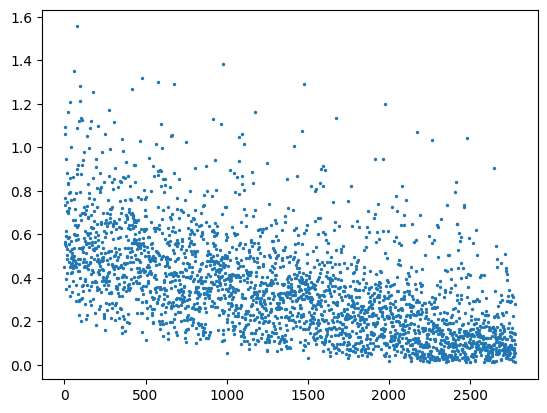

In [134]:
plt.scatter(range(2780), losses, s = [2])

In [11]:
pred = model(tf.constant(generate_embedding(36010)), shape = (1, 309, 300))

ValueError: Found zero restored functions for caller function.

In [12]:
count = 0

In [13]:
for i in tqdm(l[4500:]):
    pred = model(tf.constant(generate_embedding(i), shape = (1, 309, 300)))
    if pred <= 0.5:
        pred = 0
    else:
        pred = 1
    if data_df['classification'][i] == pred:
        count += 1
    

100%|██████████| 500/500 [02:31<00:00,  3.30it/s]


In [14]:
count*2

724

In [22]:
tf.saved_model.save(model, "../model/model_test_2")

Exception ignored in: <function tqdm.__del__ at 0x7efc552baa60>
Traceback (most recent call last):
  File "/root/miniconda3/envs/mp/lib/python3.9/site-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/root/miniconda3/envs/mp/lib/python3.9/site-packages/tqdm/std.py", line 1291, in close
    if self.last_print_t < self.start_t + self.delay:
AttributeError: 'tqdm' object has no attribute 'last_print_t'


INFO:tensorflow:Assets written to: ../model/model_test_2/assets


INFO:tensorflow:Assets written to: ../model/model_test_2/assets


In [15]:
l.clear()

In [16]:
for i in range(25400, 25500):
    l.append(i)

for i in range(46500, 46550):
    l.append(i)

In [17]:
l

[25400,
 25401,
 25402,
 25403,
 25404,
 25405,
 25406,
 25407,
 25408,
 25409,
 25410,
 25411,
 25412,
 25413,
 25414,
 25415,
 25416,
 25417,
 25418,
 25419,
 25420,
 25421,
 25422,
 25423,
 25424,
 25425,
 25426,
 25427,
 25428,
 25429,
 25430,
 25431,
 25432,
 25433,
 25434,
 25435,
 25436,
 25437,
 25438,
 25439,
 25440,
 25441,
 25442,
 25443,
 25444,
 25445,
 25446,
 25447,
 25448,
 25449,
 25450,
 25451,
 25452,
 25453,
 25454,
 25455,
 25456,
 25457,
 25458,
 25459,
 25460,
 25461,
 25462,
 25463,
 25464,
 25465,
 25466,
 25467,
 25468,
 25469,
 25470,
 25471,
 25472,
 25473,
 25474,
 25475,
 25476,
 25477,
 25478,
 25479,
 25480,
 25481,
 25482,
 25483,
 25484,
 25485,
 25486,
 25487,
 25488,
 25489,
 25490,
 25491,
 25492,
 25493,
 25494,
 25495,
 25496,
 25497,
 25498,
 25499,
 46500,
 46501,
 46502,
 46503,
 46504,
 46505,
 46506,
 46507,
 46508,
 46509,
 46510,
 46511,
 46512,
 46513,
 46514,
 46515,
 46516,
 46517,
 46518,
 46519,
 46520,
 46521,
 46522,
 46523,
 46524,


In [18]:
count2 = 0

In [19]:
for i in tqdm(l):
    pred = model(tf.constant(generate_embedding(i), shape = (1, 309, 300)))
    if pred <= 0.5:
        pred = 0
    else:
        pred = 1
    if data_df['classification'][i] == pred:
        count2 += 1

100%|██████████| 150/150 [01:15<00:00,  1.98it/s]


In [20]:
count2 / len(l)

0.6666666666666666

In [23]:
tf.keras.models.save_model(model, '../data/model_test_2')

INFO:tensorflow:Assets written to: ../data/model_test_2/assets


INFO:tensorflow:Assets written to: ../data/model_test_2/assets


In [ ]:
model.save_weights("../model/model_test_3_weights")

In [27]:
model_loaded = tf.saved_model.load('../data/model_test_2')

In [29]:
pred = model_loaded(tf.constant(generate_embedding(36010), shape = (1, 309, 300)))

ValueError: Found zero restored functions for caller function.